In [15]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
# from wpca import WPCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
from aquabyte.template_matching import find_matches_and_homography
import random
import pickle
import cv2
from copy import copy
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, Manager
import pyarrow.parquet as pq

import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

<h1> Extract base data from database </h1>

In [16]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null and b.is_qa = false;
"""
df = rds_access_utils.extract_from_database(query)

In [17]:
s3_access_utils = S3AccessUtils('/root/data')


In [18]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
df['original_world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

<h1> Generate Sample Template Matching Results </h1>

In [19]:
left_image_url, right_image_url = df.left_image_url.iloc[0], df.right_image_url.iloc[0]
left_crop_metadata, right_crop_metadata = df.left_crop_metadata.iloc[0], df.right_crop_metadata.iloc[0]
cm = df.camera_metadata.iloc[0]
keypoints = df.keypoints.iloc[0]

left_image_f, _, _ = s3_access_utils.download_from_url(left_image_url)
right_image_f, _, _ = s3_access_utils.download_from_url(right_image_url)
imageL = cv2.imread(left_image_f)
imageR = cv2.imread(right_image_f)
H, kps = find_matches_and_homography(imageL, imageR, keypoints, cm, left_crop_metadata, right_crop_metadata)

Keypoints: {'version': 2, 'leftCrop': [{'xCrop': 807, 'yCrop': 1535, 'xFrame': 807, 'yFrame': 1535, 'keypointType': 'UPPER_LIP'}, {'xCrop': 955, 'yCrop': 1572, 'xFrame': 955, 'yFrame': 1572, 'keypointType': 'EYE'}, {'xCrop': 2050, 'yCrop': 1307, 'xFrame': 2050, 'yFrame': 1307, 'keypointType': 'DORSAL_FIN'}, {'xCrop': 3034, 'yCrop': 1522, 'xFrame': 3034, 'yFrame': 1522, 'keypointType': 'ADIPOSE_FIN'}, {'xCrop': 3293, 'yCrop': 1621, 'xFrame': 3293, 'yFrame': 1621, 'keypointType': 'UPPER_PRECAUDAL_PIT'}, {'xCrop': 3495, 'yCrop': 1738, 'xFrame': 3495, 'yFrame': 1738, 'keypointType': 'HYPURAL_PLATE'}, {'xCrop': 3635, 'yCrop': 1716, 'xFrame': 3635, 'yFrame': 1716, 'keypointType': 'TAIL_NOTCH'}, {'xCrop': 3257, 'yCrop': 1831, 'xFrame': 3257, 'yFrame': 1831, 'keypointType': 'LOWER_PRECAUDAL_PIT'}, {'xCrop': 2821, 'yCrop': 1948, 'xFrame': 2821, 'yFrame': 1948, 'keypointType': 'ANAL_FIN'}, {'xCrop': 2243, 'yCrop': 1984, 'xFrame': 2243, 'yFrame': 1984, 'keypointType': 'PELVIC_FIN'}, {'xCrop': 126

In [20]:
x = find_matches_and_homography(imageL, imageR, keypoints, cm, left_crop_metadata, right_crop_metadata)

Keypoints: {'version': 2, 'leftCrop': [{'xCrop': 807, 'yCrop': 1535, 'xFrame': 807, 'yFrame': 1535, 'keypointType': 'UPPER_LIP'}, {'xCrop': 955, 'yCrop': 1572, 'xFrame': 955, 'yFrame': 1572, 'keypointType': 'EYE'}, {'xCrop': 2050, 'yCrop': 1307, 'xFrame': 2050, 'yFrame': 1307, 'keypointType': 'DORSAL_FIN'}, {'xCrop': 3034, 'yCrop': 1522, 'xFrame': 3034, 'yFrame': 1522, 'keypointType': 'ADIPOSE_FIN'}, {'xCrop': 3293, 'yCrop': 1621, 'xFrame': 3293, 'yFrame': 1621, 'keypointType': 'UPPER_PRECAUDAL_PIT'}, {'xCrop': 3495, 'yCrop': 1738, 'xFrame': 3495, 'yFrame': 1738, 'keypointType': 'HYPURAL_PLATE'}, {'xCrop': 3635, 'yCrop': 1716, 'xFrame': 3635, 'yFrame': 1716, 'keypointType': 'TAIL_NOTCH'}, {'xCrop': 3257, 'yCrop': 1831, 'xFrame': 3257, 'yFrame': 1831, 'keypointType': 'LOWER_PRECAUDAL_PIT'}, {'xCrop': 2821, 'yCrop': 1948, 'xFrame': 2821, 'yFrame': 1948, 'keypointType': 'ANAL_FIN'}, {'xCrop': 2243, 'yCrop': 1984, 'xFrame': 2243, 'yFrame': 1984, 'keypointType': 'PELVIC_FIN'}, {'xCrop': 126

In [21]:
print(type(x))

<class 'list'>


In [22]:
print(type(x[0]))

<class 'list'>


In [23]:
print(type(x[1]))

<class 'list'>


In [24]:
def get_wkps(kps, cm): 
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    wkps = []
    for kp in kps:
        p1_x_frame, p1_y_frame, p2_x_frame, p2_y_frame = kp
        disp = abs(p1_x_frame - p2_x_frame)
        depth = depth_from_disp(disp, cm)
        wkp = convert_to_world_point(p1_x_frame, p1_y_frame, depth, cm)
        wkps.append(wkp)
        
    return wkps


In [25]:
body_wkps = get_wkps(kps, cm)

<h1> Visualize World Keypoints </h1>

In [26]:
# create local util functions for body world keypoint visualizations (will override original imports)

def _generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

def _normalize_world_keypoints(wkps, rotate=True):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    translated_wkps = {bp: wkps[bp] - wkps['HYPURAL_PLATE'] for bp in body_parts}

    if not rotate:
        return translated_wkps
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps['UPPER_LIP']
    R = _generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp].T) for bp in body_parts}
    
    # perform second rotation
    u_base = np.array([0, 0, 1])
    v = norm_wkps_intermediate['ADIPOSE_FIN'] - np.array([norm_wkps_intermediate['ADIPOSE_FIN'][0], 0, 0])
    R = _generate_rotation_matrix(u_base, v)
    norm_wkps = {bp: np.dot(R, norm_wkps_intermediate[bp]) for bp in body_parts}
    
    # perform reflecton if necessary
    if norm_wkps['PECTORAL_FIN'][1] > 0:
        norm_wkps = {bp: np.array([
            norm_wkps[bp][0],
            -norm_wkps[bp][1],
            norm_wkps[bp][2]
        ]) for bp in body_parts}
    
    return norm_wkps

In [27]:
wkps = df.original_world_keypoints.iloc[0]
wkps['BODY'] = np.array(body_wkps)
norm_wkps = _normalize_world_keypoints(wkps)


<IPython.core.display.Javascript object>


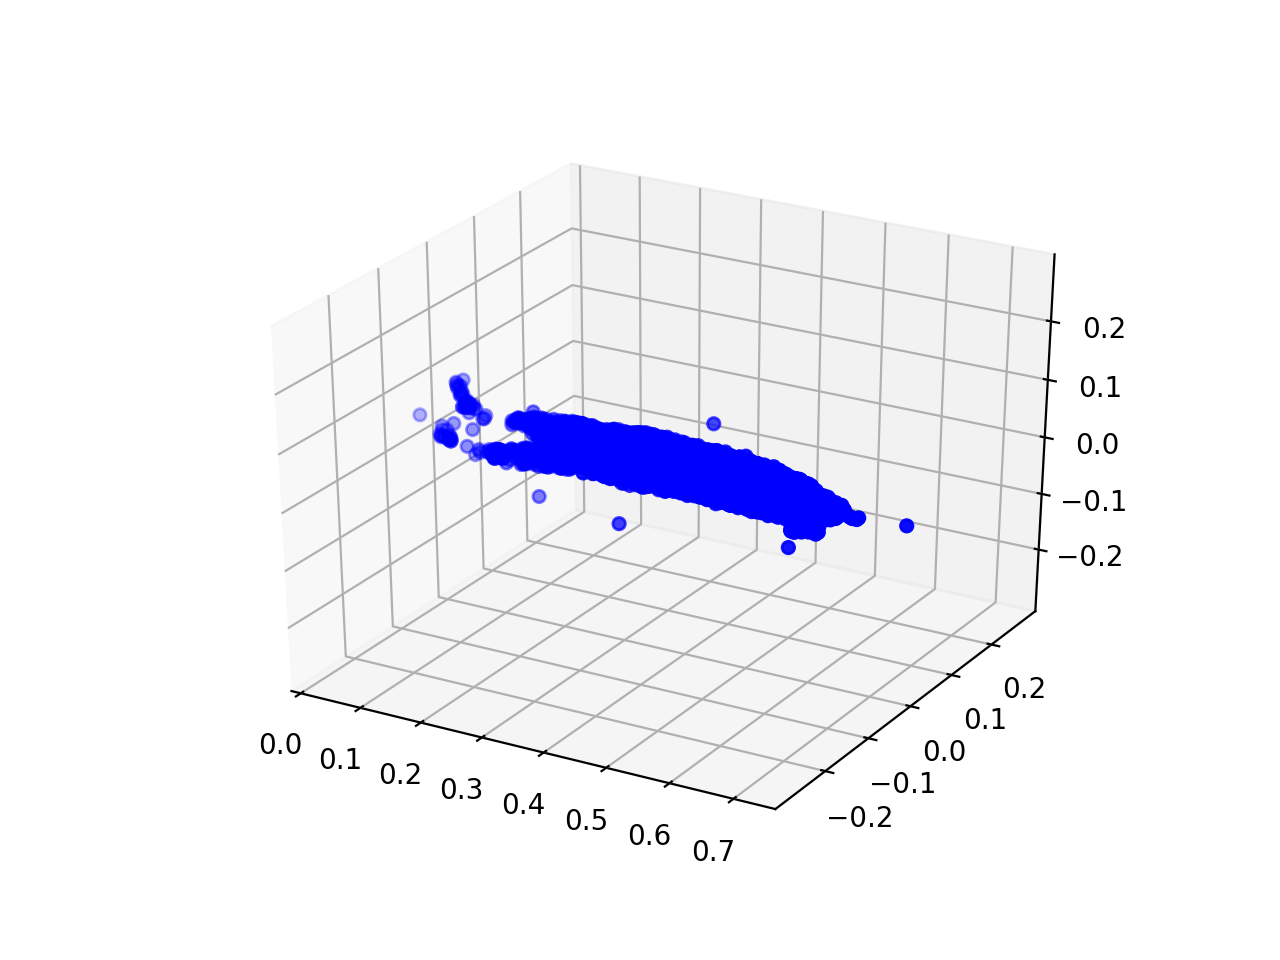

In [28]:
%matplotlib notebook
body_parts = [k for k in norm_wkps.keys() if k != 'BODY']
xs = [norm_wkps[bp][0] for bp in body_parts]
ys = [norm_wkps[bp][1] for bp in body_parts]
zs = [norm_wkps[bp][2] for bp in body_parts]
xs.extend(list(norm_wkps['BODY'][0]))
ys.extend(list(norm_wkps['BODY'][1]))
zs.extend(list(norm_wkps['BODY'][2]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, max(xs))
ax.set_ylim3d(-0.3, 0.3)
ax.set_zlim3d(-0.3, 0.3)
ax.scatter(xs, ys, zs, color='blue')

In [115]:
ps = [1/7, 3/7, 3/7]
pens = [0, 1, 2]

In [116]:
N = 1000
e_x = ps[0]
var_x = ps[0] * (1 - ps[0])
std_x = np.sqrt(var_x)

In [117]:
std_err = std_x / np.sqrt(N)

In [126]:
np.array([e_x - 2.58 * std_err, e_x + 2.58 * std_err]) * N

array([114.30772276, 171.40656295])

In [127]:
e_x * N

142.85714285714286

In [128]:
means = []
trials = 1000
for t in range(trials):
    pen_list = []
    cum_ps = np.cumsum(ps)
    for n in range(N):
        r = np.random.uniform()
        pen = 1 if r < ps[0] else 0
        pen_list.append(pen)
    mean = np.mean(pen_list)
    means.append(mean)


In [129]:
means = np.array(means)

In [130]:
len(means[(means > e_x - 2.58 * std_err) & (means < e_x + 2.58 * std_err)])

988

In [123]:
len(means)

1000